In [350]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import splprep
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import scipy.stats
from sklearn.metrics import r2_score
from sklearn import preprocessing
import pickle
import pandas as pd
import math
import functions
import matplotlib.colors
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [272]:
#plt.style.use("seaborn-v0_8-paper")
import seaborn as sns
plt.style.use("seaborn-v0_8")
#sns.set(font_scale=1,font="Verdana")
#sns.set_style("darkgrid", {"axes.facecolor": ".9",'grid.color': 'whitesmoke'})
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

## Load data

In [312]:
bat_dict = functions.load_batdict()

# Discharge-Voltage Curve

In [313]:
id = "b1c1"
cycle = "1"

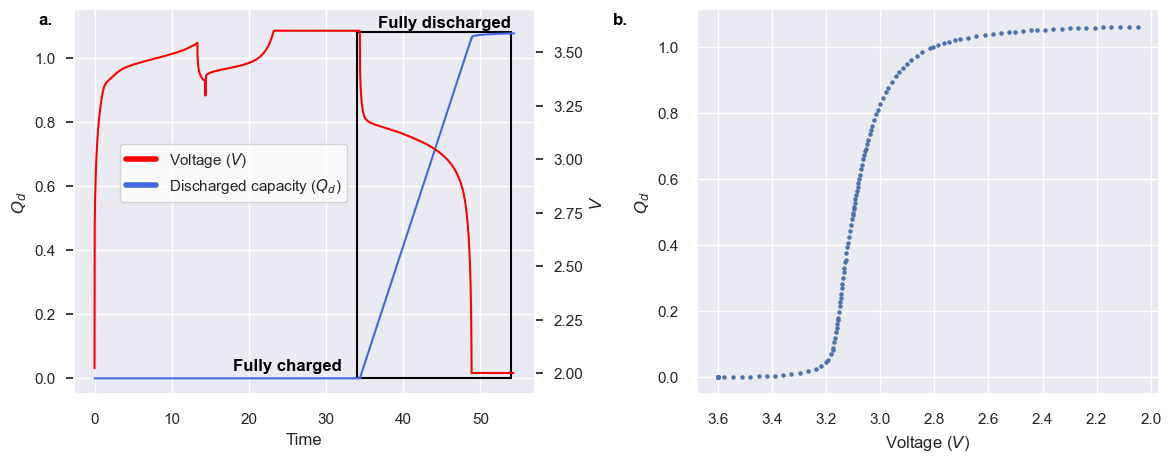

In [316]:
sns.set(font_scale=1)
fig,axs=plt.subplots(ncols=2, figsize=(14,5))
# left subpanel
ax = axs[0]
ax2 = ax.twinx()  
ax.plot(bat_dict[id]["cycles"][cycle]["t"],bat_dict[id]["cycles"][cycle]["Qd"],color="royalblue")
ax2.plot(bat_dict[id]["cycles"][cycle]["t"][:-5],bat_dict[id]["cycles"][cycle]["V"][:-5],color="red")
ax2.grid(False)
ax.set_ylim([-0.05,1.15])
ax2.set_ylim([1.9,3.7])

ax.set_xlabel("Time")
ax.set_ylabel("$Q_d$")
ax2.set_ylabel("$V$",fontweight="semibold")
ax.text(x=18,y=0.025,s="Fully charged",fontsize=12,color="black",fontweight="semibold")
ax.text(x=36.75,y=1.095,s="Fully discharged",fontsize=12,color="black",fontweight="semibold")
ax.text(x=0.1,y=0.85,s="a.",color="black",fontweight="semibold",transform=plt.gcf().transFigure)

legend_elements = [Line2D([0], [0], color='red', lw=4, label='Voltage ($V$)'),
                   Line2D([0], [0], color='royalblue', lw=4, label='Discharged capacity ($Q_d$)')]
ax.legend(handles=legend_elements,loc=(0.1,0.5),fancybox=True,frameon=True,facecolor="white")

rect = patches.Rectangle((34, 0), 20, 1.08, linewidth=1.5, edgecolor='black', facecolor='none')
ax.add_patch(rect)

ax = axs[1]
x = bat_dict[id]["cycles"][cycle]["V"][600:-100:3]
y = bat_dict[id]["cycles"][cycle]["Qd"][600:-100:3]
ax.scatter(x,y,s=5)
ax.invert_xaxis()
ax.set_xlabel("Voltage ($V$)")
ax.set_ylabel("$Q_d$")
ax.text(x=0.51,y=0.85,s="b.",color="black",fontweight="semibold",transform=plt.gcf().transFigure)
fig.subplots_adjust(wspace=0.35)
#plt.savefig("images/Qd_V_cycle_v2.png",dpi=300)

# Curve Shifting and $\Delta Q_{100-10}(V)$

In [198]:
def plot_cycles(id,ax,colors):
    for j in range(100,2,-30):
        x,y = functions.crop_data(bat_dict,id,str(j))
        ax.plot(x,y,color=colors[j-1])
        ax.set_ylim([0.45,1.1])
        ax.set_xlim([2,3.55])

C:\Users\kyan3\AppData\Local\Temp\ipykernel_4424\3025783668.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ix = int(len(colors)*(cycle_life-150)/(2300-150))


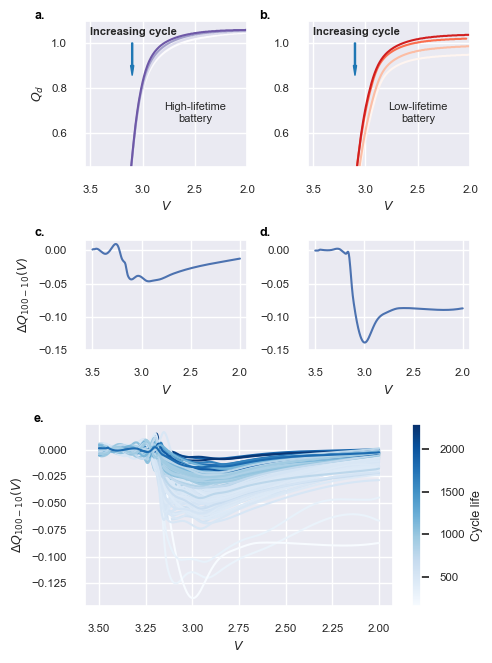

In [261]:
fig = plt.figure(figsize=(5, 7))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 0.75, 1.25])
sns.set(font_scale=0.75)
#sns.set_style("darkgrid", {"axes.facecolor": ".85",'grid.color': 'whitesmoke'})

# Create subplots in the grid
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, 0])
ax4 = plt.subplot(gs[1, 1])

# Plot something in each subplot
colors = plt.cm.Purples_r(np.linspace(0.2,1,100))
plot_cycles("b2c10",ax1,colors)
ax1.set_xlim([2,3.55])
ax1.invert_xaxis()
ax1.set_xlabel("$V$",fontweight="semibold")
ax1.set_ylabel("$Q_d$",fontweight="semibold")
ax1.arrow(3.1,1,0,-0.1,width=0.01,color="tab:blue")
ax1.text(3.5,1.035,"Increasing cycle",fontsize=8,fontweight="semibold")
ax1.text(2.5,0.65,"High-lifetime\nbattery",fontsize=8,horizontalalignment="center")
ax1.text(x=0.075,y=0.925,s="a.",color="black",fontweight="semibold",transform=plt.gcf().transFigure)

colors = plt.cm.Reds_r(np.linspace(0.2,1,100))
plot_cycles("b2c1",ax2,colors)
ax2.set_xlim([2,3.55])
ax2.invert_xaxis()
ax2.set_xlabel("$V$",fontweight="semibold")
ax2.arrow(3.1,1,0,-0.1,width=0.01,color="tab:blue")
ax2.text(3.5,1.035,"Increasing cycle",fontsize=8,fontweight="semibold")
ax2.text(2.5,0.65,"Low-lifetime\nbattery",fontsize=8,horizontalalignment="center")
ax2.text(x=0.525,y=0.925,s="b.",color="black",fontweight="semibold",transform=plt.gcf().transFigure)

x = np.linspace(2,3.5,1000)
y = functions.get_deltaQ(bat_dict,"b2c10")
ax3.plot(x,y)
ax3.invert_xaxis()
ax3.set_ylim([-0.15,0.015])
ax3.set_xlabel("$V$")
ax3.set_ylabel("$\Delta Q_{100-10}(V)$")
ax3.text(x=0.075,y=0.615,s="c.",color="black",fontweight="semibold",transform=plt.gcf().transFigure)

y = functions.get_deltaQ(bat_dict,"b2c1")
ax4.plot(x,y)
ax4.invert_xaxis()
ax4.set_ylim([-0.15,0.015])
ax4.set_xlabel("$V$")
ax4.text(x=0.525,y=0.615,s="d.",color="black",fontweight="semibold",transform=plt.gcf().transFigure)

# Create a subplot below with double width
ax_big = plt.subplot(gs[2, :])

colors = plt.cm.Blues(np.linspace(0,1,len(bat_dict.keys())))
for id in bat_dict.keys():
    cycle_life = bat_dict[id]["cycle_life"]
    ix = int(len(colors)*(cycle_life-150)/(2300-150))
    y = functions.get_deltaQ(bat_dict,id)
    ax_big.plot(x,y,color=colors[ix])
ax_big.set_xlabel("$V$",fontweight="semibold")
ax_big.set_ylabel("$\Delta Q_{100-10}(V)$",fontweight="semibold")
ax_big.invert_xaxis()
ax_big.text(x=0.075,y=0.35,s="e.",color="black",fontweight="semibold",transform=plt.gcf().transFigure)
norm = matplotlib.colors.Normalize(vmin=150, vmax=2300) 
plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap="Blues"),ax=ax_big,label="Cycle life")

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("images/curve_shift_v2",dpi=300)

# Curve Fits

In [263]:
bat_dict = pickle.load(open(r'Data/bat_dict_small.pkl', 'rb'))

In [264]:
def func(x, a, b):
    return np.exp(a)*x**b

In [267]:
params = []
true_cycle_lives = []
fit_cycle_lives = []
true_gammas = []
for id in bat_dict.keys():
    bat = bat_dict[id]
    #temps = np.mean(bat['summary']['Tavg'][1:cutoff])+273
    Y = 1-bat['summary']['QD'][1:]/1.1
    length = len(bat['summary']['QD'][1:])
    x = np.arange(1,length+1)
    def parameter_estimation_function(x):
        return np.asarray(Y) - func(x=np.arange(1,len(Y)+1), a=x[0],b=x[1])- Y[0]
    
    param = least_squares(parameter_estimation_function, [-30,3], max_nfev = 4000)

    alpha = param.x[0]
    beta = param.x[1]
    params.append([alpha,beta])

    true_cycle_lives.append(bat["cycle_life"][0])
    fit_cycle_lives.append([np.power(np.exp(-alpha)*(0.2-Y[0]),1/beta)])
    true_gammas.append([Y[0]])
params = np.array(params)
true_cycle_lives = np.array(true_cycle_lives)
fit_cycle_lives = np.array(fit_cycle_lives)
true_gammas = np.array(true_gammas)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


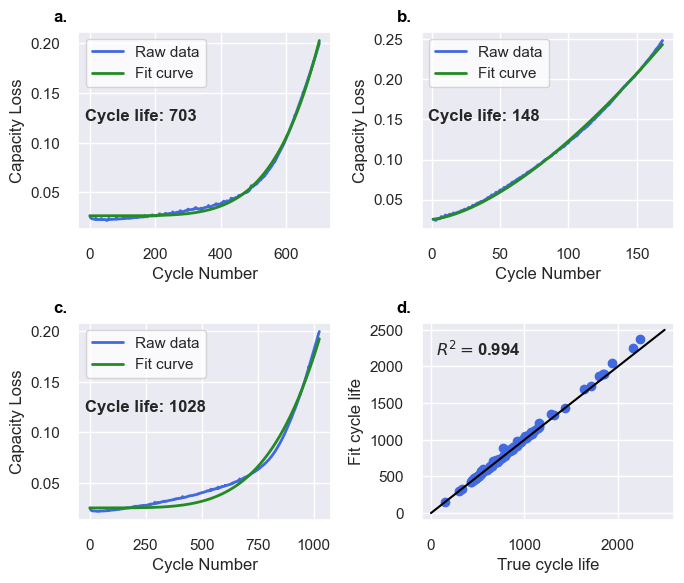

In [308]:
# visualizing a subset of curve fits for batteries with varying cycle lives
sns.set(font_scale=1)
fig,axs=plt.subplots(ncols=2,nrows=2,figsize=(7,6))
ids = ["b1c35","b2c1","b3c26"]
letters = ["a","b","c"]
for ix,id in enumerate(ids):
    ax = axs[int(ix/2)][ix%2]
    length = len(bat_dict[id]['summary']['QD'][1:])
    x = np.arange(1,length+1)
    Y = 1-bat_dict[id]['summary']['QD'][1:]/1.1
    ax.plot(x, Y,linewidth=2, color="royalblue")

    param = least_squares(parameter_estimation_function, [-30,3], max_nfev = 4000)

    alpha = param.x[0]
    beta = param.x[1]
    Y_hat = func(x,alpha,beta)+Y[0]
    ax.plot(x, func(x,alpha,beta)+Y[0], linewidth=2, color="forestgreen")

    ax.set_xlabel("Cycle Number")
    ax.set_ylabel("Capacity Loss")
    ax.legend()

    legend_elements = [Line2D([0], [0], color='royalblue', lw=2, label="Raw data"),
                   Line2D([0], [0], color='forestgreen', lw=2, label="Fit curve")]
    ax.legend(handles=legend_elements,fancybox=True,frameon=True,facecolor="white")

    ax.text(0.025,0.55,"Cycle life: "+str(int(bat_dict[id]["cycle_life"][0,0])),fontweight="semibold",transform=ax.transAxes)
    ax.text(x=-0.1,y=1.05,s=f"{letters[ix]}.",color="black",fontweight="semibold",transform=ax.transAxes)
    rsq = r2_score(Y,Y_hat)
    #ax.text(0.025,0.675,"$R^2:$"+str(round(rsq,3)),fontsize=12, fontweight="semibold",transform=ax.transAxes)
    #ax.text(-0.175,0.925,letters[ix]+".",fontsize=14,fontweight="semibold",transform=ax.transAxes)

ax = axs[1][1]
ax.scatter(true_cycle_lives,fit_cycle_lives,color="royalblue")
ax.plot(np.linspace(0,2500),np.linspace(0,2500),color="black")
ax.set_xlabel("True cycle life")
ax.set_ylabel("Fit cycle life")
r_sq = r2_score(true_cycle_lives[:,0],fit_cycle_lives[:,0])
ax.text(50,2150,"$R^2=$"+str(round(r_sq,3)),fontweight="semibold")
ax.text(x=-0.1,y=1.05,s=f"d.",color="black",fontweight="semibold",transform=ax.transAxes)
ax.set_xlim([-100,2600])
ax.set_ylim([-100,2600])

fig.tight_layout()
plt.savefig("images/curve_fits_v2.png",dpi=300)

In [320]:
print(f"R2 score: {r2_score(true_cycle_lives[:,0],fit_cycle_lives[:,0])}")

R2 score: 0.994268075937878


In [321]:
print(f"RMSE: {np.mean((true_cycle_lives[:,0]-fit_cycle_lives[:,0])**2)**0.5}")

RMSE: 28.63202482903471


# Model Predictions

In [333]:
class AttentionModel(torch.nn.Module):
    def __init__(self, d_model, feat_dim, n_cycle, vdim=1, num_heads=1, attn_model="softmax", beta=1, skip_connect=0):
        super(AttentionModel, self).__init__()
        '''d_model: embedding dimension; can be chosen independently of input data dimensions
           feat_dim: dimension of each feature
           n_cycle: number of features being fed in
           vdim: dimension of output
           num_heads: could theoretically support multihead attention; has not been built in yet
           attn_model: default softmax; code also supports batch normalized attention with keyword "batch_norm"
           beta: if using batch normalized attention, beta is the weight placed on the mean
           skip_connect: whether or not to add a skip connection. If 0, no skip connection. If 1, H=AV+B where B
           is a trainable projection of the input X. If 2, H=AV+V'''
        assert d_model % num_heads == 0, "Embedding dimension (d_model) must be divisible by number of attention heads (num_heads)."
        
        self.W_q = nn.Linear(feat_dim, d_model)
        self.W_k = nn.Linear(feat_dim, d_model)
        self.W_v = nn.Linear(feat_dim, vdim)
        self.W_b = nn.Linear(feat_dim, vdim)

        self.create_output = nn.Linear(n_cycle,1) # final linear layer to collapse output

        self.d_model = d_model
        self.vdim = vdim
        self.num_heads = num_heads
        #self.head_dim = d_model // num_heads
        
        self.attn_model = attn_model
        self.beta = beta
        self.skip_connect = skip_connect

    def scaled_dot_product_attention(self, Q, K, V, B): 
        '''softmax attention'''
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_model // self.num_heads)
        attn_probs = torch.softmax(attn_scores, dim=-1) # attention matrix, dimensionality (batch size, n_cycle, n_cycle)
        output = torch.matmul(attn_probs, V) # dimensionality (batch size, n_cycle, vdim)
        if self.skip_connect == 1:
            output = output + B
        elif self.skip_connect == 2:
            output = output + V
        return output
    
    def batch_normalized_attention(self, Q, K, V, B):
        '''batch normalized attention'''
        mu = torch.mean(K,0)
        s = torch.std(K,0,correction=0)
        attn_scores = torch.matmul(torch.mul(Q-self.beta*mu,s), torch.mul(K-self.beta*mu,s).transpose(-2,-1)) / math.sqrt(self.d_model)
        attn_probs = torch.softmax(attn_scores, dim=-1) # attention matrix, dimensionality (batch size, batch size)
        output = torch.matmul(attn_probs, V)
        if self.skip_connect == 1:
            output = output + B
        elif self.skip_connect == 2:
            output = output + V
        return output
    
    def forward(self, X):
        if len(X.size()) < 3:
            X = X[...,None] # add a feature dimension if there is none
        Q = self.W_q(X) # create query matrix, dimensionality (batch size, n_cycle, d_model)
        K = self.W_k(X) # create key matrix, dimensionality (batch size, n_cycle, d_model)
        V = self.W_v(X) # create value matrix, dimensionality (batch size, n_cycle, vdim)
        B = self.W_b(X) # create matrix for skip connection, dimensionality (batch size, n_cycle, vdim)

        # replaced final linear layer with just an averaging layer (gave better results earlier, can try putting linear layer back) 
        if self.attn_model=="softmax": attn_output = self.scaled_dot_product_attention(Q, K, V, B)
        elif self.attn_model=="batch_norm": attn_output = self.batch_normalized_attention(Q, K, V, B)
        # attn_output has dimensionality (batch_sizeS, n_cycle, vdim)
        output = torch.mean(attn_output.transpose(-2,-1),dim=-1) # dimensionality (batch_size, vdim)
        #output = self.create_output(attn_output.transpose(-2,-1)) # dimensionality (batch size, 1, 1)
        return output

In [341]:
settings = {"input_file": "Data/features5.csv", # name of file with input data
            "input_indices": [1,2,3,14,15], # column indices of features to feed in
            "scale_input": False, "scale_output": False, # whether or not to normalize input/output data
            "d_model": 2, "vdim": 2, "feat_dim": 1, "skip_connect": 0, "batch_size": 1, "attn_model": "softmax", # self-attention parameters
            "nepoch_coarse": 800, "nepoch_fine": 3000, # number of epochs for first and second training stages
            "lr_coarse": 1e-3, "lr_fine": 5e-5, # learning rate for first and second training stages
            "curve_loss": False, "n_points": 100, "curve_weight": 0.01, # do we include diff bw curves in loss function?
            'weighted_points': True, # do we have variable weights for different points when calculating curve loss?
            "param_weights": torch.Tensor([1/32, 1]), # do we vary how much to weight each parameter in loss? can use to normalize param magnitudes
            "verbose": True, "illustrative":True}  #verbose prints error every 100 epochs; illustrative creates visualization plots

In [339]:
model = AttentionModel(d_model=settings["d_model"],feat_dim=settings["feat_dim"],n_cycle=len(settings["input_indices"]),
        vdim=settings["vdim"],attn_model=settings["attn_model"],skip_connect=settings["skip_connect"])
model_weights = torch.load("Physics/model_stage2")
model.load_state_dict(model_weights)
model.eval()

AttentionModel(
  (W_q): Linear(in_features=1, out_features=2, bias=True)
  (W_k): Linear(in_features=1, out_features=2, bias=True)
  (W_v): Linear(in_features=1, out_features=2, bias=True)
  (W_b): Linear(in_features=1, out_features=2, bias=True)
  (create_output): Linear(in_features=5, out_features=1, bias=True)
)

In [349]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122])

In [351]:
def prep_data(settings, params, true_cycle_lives, fit_cycle_lives,scale_input=False,scale_output=False):
    '''creates tensor datasets with data needed to train, test, and validate model'''
    data = np.loadtxt(settings["input_file"],delimiter=',',skiprows=1) # skip row for column names

    x_train = data[:,settings["input_indices"]][train_ind] # features for prediction
    y_train = params[train_ind] # A and B (ground truth parameters for fit curve)
    true_life_train = true_cycle_lives[train_ind] # actual cycle life of battery
    fit_life_train = fit_cycle_lives[train_ind] # ground truth cycle life of battery
    true_gammas_train = true_gammas[train_ind] # true intercept of capacity loss curve

    x_test = data[:,settings["input_indices"]][test_ind]
    y_test = params[test_ind]
    true_life_test = true_cycle_lives[test_ind]
    fit_life_test = fit_cycle_lives[test_ind]
    true_gammas_test = true_gammas[test_ind]

    x_stest = data[:,settings["input_indices"]][secondary_ind]
    y_stest = params[secondary_ind]
    true_life_stest = true_cycle_lives[secondary_ind]
    fit_life_stest = fit_cycle_lives[secondary_ind]
    true_gammas_stest = true_gammas[secondary_ind]

    if scale_input: # scales input along feature dimension to have mean zero and SD one
        in_scaler = preprocessing.StandardScaler().fit(list(x_train))
        x_train = in_scaler.transform(list(x_train))
        x_test = in_scaler.transform(list(x_test))
        x_stest = in_scaler.transform(list(x_stest))

    if scale_output: # scales output parameters to have mean zero and SD one
        mean = np.mean(y_train,axis=0)
        sd = np.std(y_train,axis=0)
        y_train = (y_train-mean)/sd
        y_test = (y_test-mean)/sd
        y_stest = (y_stest-mean)/sd

    train = TensorDataset(torch.Tensor(x_train),torch.Tensor(y_train),torch.Tensor(true_life_train),torch.Tensor(fit_life_train),torch.Tensor(true_gammas_train))
    test = TensorDataset(torch.Tensor(x_test),torch.Tensor(y_test),torch.Tensor(true_life_test),torch.Tensor(fit_life_test),torch.Tensor(true_gammas_test))
    stest = TensorDataset(torch.Tensor(x_stest),torch.Tensor(y_stest),torch.Tensor(true_life_stest),torch.Tensor(fit_life_stest),torch.Tensor(true_gammas_stest))
    
    if scale_output: return train,test,stest,mean,sd
    else: return train,test,stest

In [342]:
data = np.loadtxt(settings["input_file"],delimiter=',',skiprows=1) # skip row for column names
x_all = data[:,settings["input_indices"]]
y_all = params
true_life_all = true_cycle_lives
fit_life_all = fit_cycle_lives
true_gammas_all = true_gammas

In [352]:
train, test, stest = prep_data(settings,params,true_cycle_lives,fit_cycle_lives,settings["scale_input"],settings["scale_output"])

In [343]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [398]:
def make_scatter_plot(ax,train,test,stest):
    colors = ["blue","red","orange"]
    markers = ["o","v","s"]
    sizes = [5,6,5]
    parameter_results = {0:[[], []], 1:[[], []], 2:[[], []]} #0: train, 1: test, 2: secondary test
    ix = 0

    for i,dataset in enumerate([train,test,stest]):
        predicted =[]
        labels = []

        # perform prediction for each battery
        for cell in dataset:
            input, label, true_life, _, true_gamma = cell
            pred = model(input[None,:].to(device)).detach().numpy()[0]
            if settings["scale_output"]: 
                pred = pred*settings["output_sd"]+settings["output_mean"]
                label = label*settings["output_sd"]+settings["output_mean"]
            pred_life = np.power(np.exp(-pred[0])*(0.2-true_gamma[0]),1/pred[1])

            parameter_results[i][0].append(label.detach().numpy())
            parameter_results[i][1].append(pred)
            predicted.append(pred_life)
            labels.append(true_life[0])

        ax.plot(labels, predicted, markers[i],color=colors[i],markersize=sizes[i])
        ax.set_xlabel("Truth")
        ax.set_ylabel("Predicted")

    # plot predicted vs. actual cycle lives
    ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
    ax.set_ylim([0,2600])
    ax.set_xlim([0,2600])
    #ax.set_title("Battery Life Predictions",fontweight="semibold")

    legend_elements = [Line2D([0], [0], marker='o', color="w", label='Train',
                          markerfacecolor='blue', markersize=12),
                          Line2D([0], [0], marker='v', color="w", label='Test',
                          markerfacecolor='red', markersize=12),
                          Line2D([0], [0], marker='s', color="w", label='Secondary test',
                          markerfacecolor='orange', markersize=12)]
    ax.legend(handles=legend_elements,fancybox=True,frameon=True,facecolor="white")
    ax.set_title("Cycle Life Prediction",fontweight="semibold")
    ax.text(-0.1,1.035,"a.",fontweight="semibold",transform=ax.transAxes)

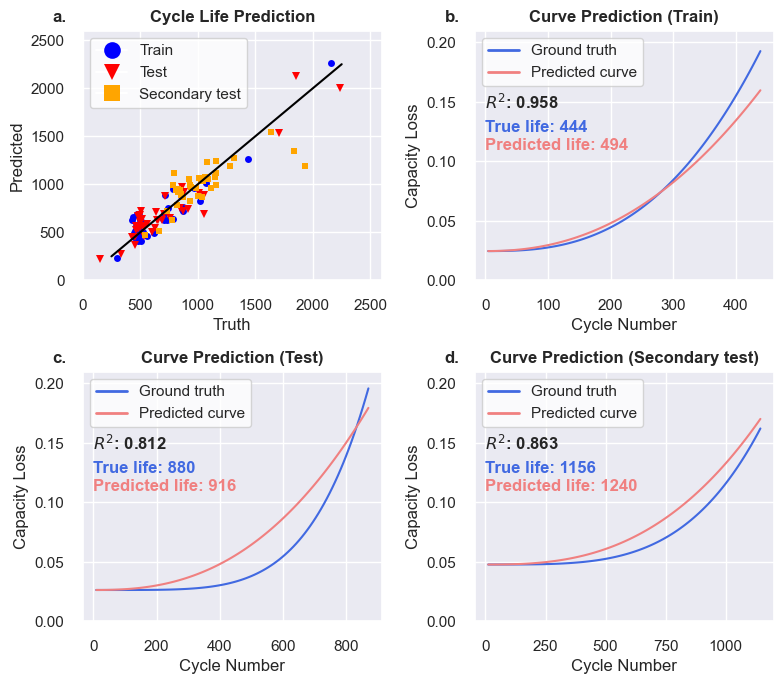

In [403]:
#fig,axs=plt.subplots(nrows=2,ncols=2,figsize=(8,7))
fig = plt.figure(figsize=(8,7))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])
ax = plt.subplot(gs[0, 0])
make_scatter_plot(ax,train,test,stest)

letters = ["b","c","d"]
titles = ["Train","Test","Secondary test"]
for i,idx in enumerate([45,10,119]):
    #ax = axs[int((i+1)/2)][(i+1)%2]
    ax = plt.subplot(gs[int((i+1)/2),(i+1)%2])
    cell =(torch.Tensor(x_all[idx]),torch.Tensor(y_all[idx]),torch.Tensor(true_life_all[idx]),
        torch.Tensor(fit_life_all[idx]),torch.Tensor(true_gammas_all[idx]))
    input, label, true_life, _, true_gamma = cell
    pred = model(input[None,:].to(device)).detach().numpy()[0]
    pred_life = np.power(np.exp(-pred[0])*(0.2-true_gamma),1/pred[1])

    if settings["scale_output"]: 
        pred = pred*settings["output_sd"]+settings["output_mean"]
        label = label*settings["output_sd"]+settings["output_mean"]

    n = 100
    x = torch.Tensor(np.arange(1,n))
    fit_curve = torch.exp(label[0])*torch.pow(x*(true_life/n),label[1])+true_gamma
    pred_curve = np.exp(pred[0])*np.power(x*(true_life/n),pred[1])+true_gamma

    ax.plot(x*(true_life/n),fit_curve,color="royalblue")
    ax.plot(x*(true_life/n),pred_curve,color="lightcoral")

    ax.set_xlabel("Cycle Number")
    ax.set_ylabel("Capacity Loss")

    legend_elements = [Line2D([0], [0], color='royalblue', lw=2, label="Ground truth"),
                   Line2D([0], [0], color='lightcoral', lw=2, label="Predicted curve")]
    ax.legend(handles=legend_elements,fancybox=True,frameon=True,facecolor="white",loc="upper left")

    rsq = r2_score(fit_curve.numpy(),pred_curve)
    ax.text(0,0.145,"$R^2$: "+str(round(rsq,3)), fontweight="semibold")
    ax.text(0,0.125,"True life: "+str(int(true_life)), fontweight="semibold",color="royalblue")
    ax.text(0,0.11,"Predicted life: "+str(int(pred_life)), fontweight="semibold",color="lightcoral")
    ax.set_ylim(0,0.21)
    ax.text(-0.1,1.035,letters[i]+".",fontweight="semibold",transform=ax.transAxes)
    ax.set_title(f"Curve Prediction ({titles[i]})",fontweight="semibold")

fig.tight_layout()
plt.savefig("images/predictions_v2.png", dpi=300)

# Error bar chart

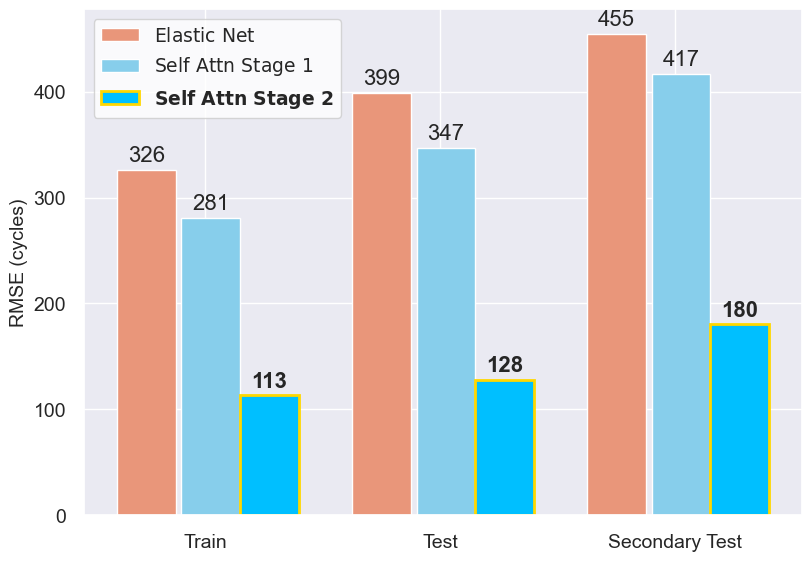

In [407]:
errors = ("Train", "Test", "Secondary Test")
model_errors = {
    '$\mathrm{Elastic \ Net}$': (326, 399, 455),
    '$\mathrm{Self \ Attn \ Stage \ 1}$': (281, 347, 417),
    '$\mathbf{Self \ Attn \ Stage \ 2}$': (113, 128, 180),
}
colors = ["darksalmon","skyblue","deepskyblue"]

x = np.arange(len(errors))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for i, (model, error) in enumerate(model_errors.items()):
    offset = width * multiplier
    if i%3==2: 
        rects = ax.bar(x + offset, error, width, label=model,color=colors[i],edgecolor="gold",linewidth=2)
        ax.bar_label(rects, padding=3,fontsize=16,fontweight="semibold")
    else: 
        rects = ax.bar(x + offset, error, width, label=model,color=colors[i])
        ax.bar_label(rects, padding=3,fontsize=16)
    if i%3==0: multiplier += 1.1
    else: multiplier +=1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE (cycles)',fontsize=14)
ax.set_xticks(x + width, errors,fontsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.legend(loc='upper left',fontsize=13.5,fancybox=True,frameon=True,facecolor="white")
plt.savefig("images/error_bars_v2.png",dpi=300)